# Set Environment
Import the libaries need to handle tables in tab-delimited files and generate meaningful plots.

In [12]:
import pandas as pd # used to handle dataframes/tables
import numpy as np # scientific computing python library
# used to make plots
import seaborn as sns 
import matplotlib.pyplot as plt
from textwrap import wrap
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

# categorical ordered type
from pandas.api.types import CategoricalDtype

# Characterizing Artificial Signal Regions
Previous work hypothesized that most artificial signals are due to issues in genome assembly rather than other factors (Amemiya 2019). In this notebook we perform Monte Carlo simulations to estimate compare often assembly gaps are found near artificial signal regions verses non-artificial signal regions.

Random sampling of 1kb regions was performed at 100 locations and the number of 1kb regions that were within 0 to 1kb of an assembly gap was measured. The sampling was repeated a thousand times.

## Assembly Gaps
First we import the table that contains the number of regions respectively out of 100 that overlap an assembly gap.

In [13]:
# file path to table
table_file="../data/artifSign_n100_len1000_dist1000_assembly_gaps_rep1000.tsv"
# read in table
table_df = pd.read_csv(table_file, sep="\t")

In [14]:
table_df.head()

,ver,gs,bl,non-AS
0,1,7,9,1
1,2,18,14,0
2,3,5,9,0
3,4,10,10,0
4,5,11,8,0


We expect these values to be normally distributed.

Text(0.5, 0.98, 'Count of regions near assembly gaps (out of 100) given 1000 trials of random sampling')

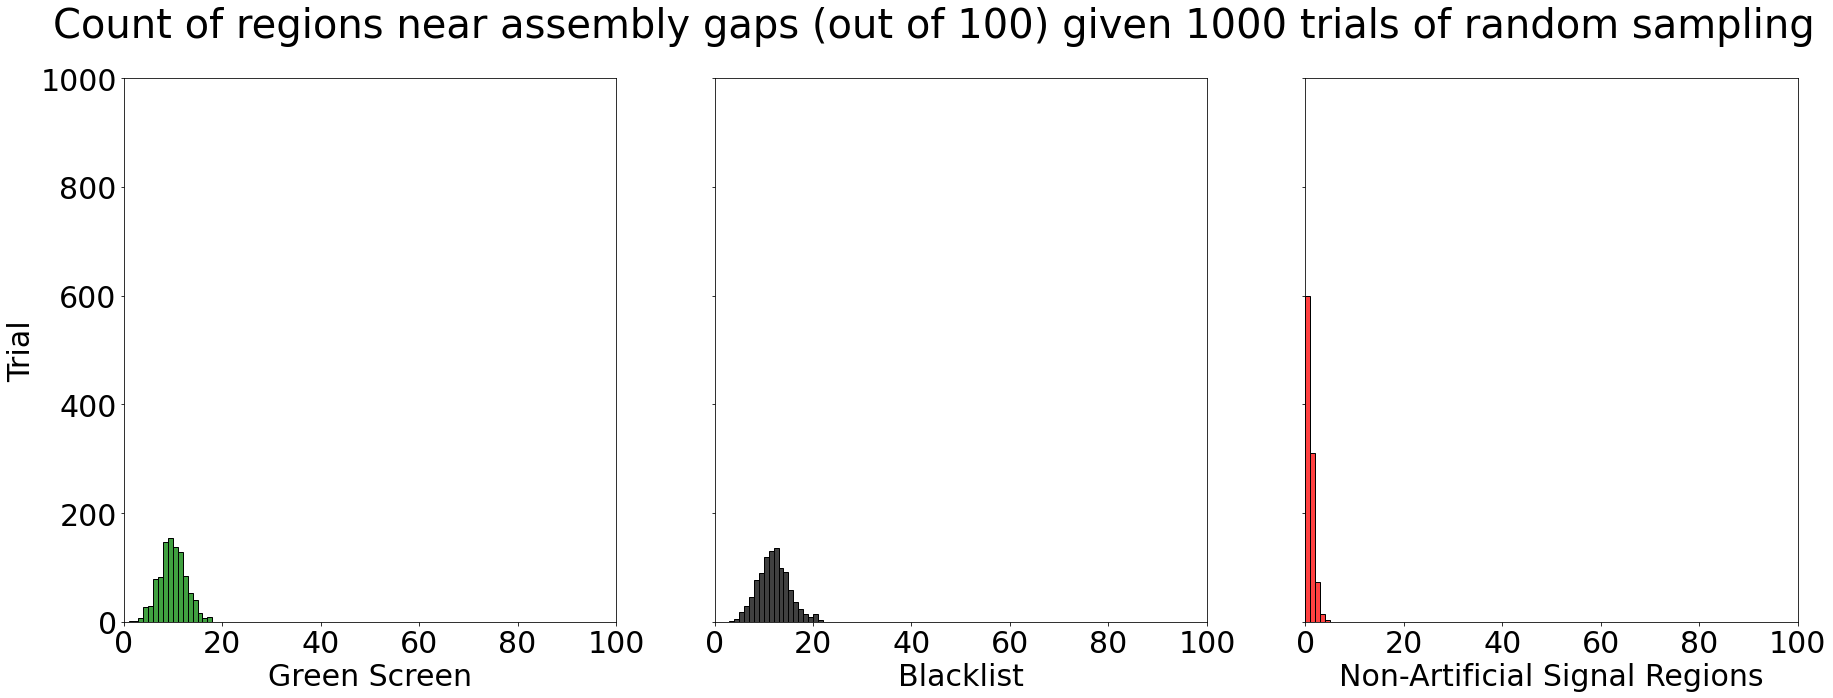

In [15]:
font = {'size'   : 30}

plt.rc('font', **font)

fig, axs = plt.subplots(1, 3, figsize=(30, 10), sharey=True)

sns.histplot(data=table_df, x="gs", 
             binwidth=1, ax=axs[0],
            color='green')
sns.histplot(data=table_df, x="bl", 
             binwidth=1, ax=axs[1],
            color='black')
sns.histplot(data=table_df, x="non-AS", 
             binwidth=1, ax=axs[2],
            color='red')
axs[0].set_xlabel('Green Screen')
axs[1].set_xlabel('Blacklist')
axs[2].set_xlabel('Non-Artificial Signal Regions')
axs[0].set_ylabel("Trial")
plt.setp(axs, xlim=(0,100), ylim=(0,1000))
fig.suptitle('Count of regions near assembly gaps (out of 100) given 1000 trials of random sampling',fontsize=40)


Let's look at the variance of these results using a box plot.

In [16]:

melt_df = pd.melt(table_df, id_vars=['ver'], value_vars=['gs','bl','non-AS'])

In [17]:
mask_cat_type = CategoricalDtype(categories=["gs","bl", "non-AS"], ordered=True)
melt_df["variable"] = melt_df["variable"].astype(mask_cat_type)
melt_df["variable"].cat.remove_unused_categories(inplace=True)

/home/sklasfeld/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


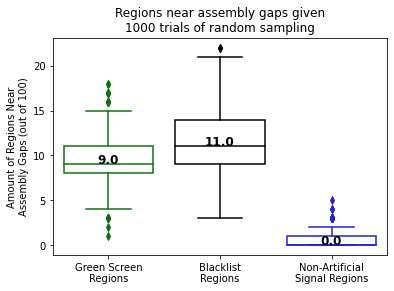

In [22]:
fig,(ax1) = plt.subplots(1)

font = {'size'   : 10}

plt.rc('font', **font)
box_plot = sns.boxplot(x="variable", y="value", data=melt_df, ax=ax1,
            palette=sns.color_palette(["green","black","blue"]))
long_title="Regions near assembly gaps given 1000 trials of random sampling"
plt.title("\n".join(wrap(long_title, 36)))
plt.xlabel('')
plt.xticks([0, 1, 2], ['Green Screen\nRegions', 'Blacklist\nRegions', 'Non-Artificial\nSignal Regions'])
long_ylabel="Amount of Regions Near Assembly Gaps (out of 100)"
plt.ylabel("\n".join(wrap(long_ylabel,30)))

for i,artist in enumerate(ax1.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax1.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
        
medians = melt_df.groupby(['variable'])['value'].median()
vertical_offset = melt_df['value'].median() * 0.01 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,np.round(medians[xtick],2), 
            horizontalalignment='center',size='large',color='k',weight='semibold')

In [19]:
stat, p = mannwhitneyu(table_df["gs"], 
                     table_df["non-AS"],
                    alternative="greater",
                    use_continuity=True)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=999557.500, p=0.000
Different distribution (reject H0)


In [20]:
stat, p = mannwhitneyu(table_df["bl"], 
                     table_df["non-AS"],
                    alternative="greater",
                    use_continuity=True)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=999970.500, p=0.000
Different distribution (reject H0)


In [21]:
?mannwhitneyu